<a href="https://colab.research.google.com/github/Sankarsh-Sunku/Implementation-Of-DL-in-Pytorch/blob/main/FFN/Weight_Histograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

In [3]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [4]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [5]:
### exploring the "innards" of the model

# create a temp model to explore
net = createTheMNISTNet()[0]

# summary of the entire model
print('Summary of model:')
print(net)
print(' ')

# # explore one of the layers
# print('Summary of input layer:')
# print( vars(net.input) )
# print(' ')

# # check out the matrix of weights
# print('Input layer weights:')
# print( net.input.weight.shape )
# print( net.input.weight )
# print(' ')

# # finally, extract the weights and make a histogram
# w = net.input.weight.detach().flatten()
# plt.hist(w,40)
# plt.xlabel('Weight value')
# plt.ylabel('Count')
# plt.title('Distribution of initialized input-layer weights')
# plt.show()

Summary of model:
mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)
 


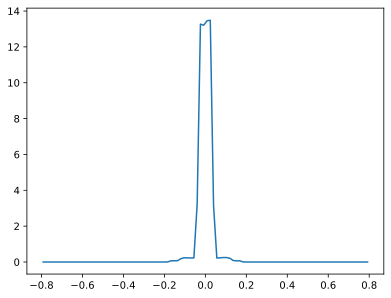

In [6]:
# a function that returns a histogram of all weights (across all layers)

def weightsHistogram(net):

  # initialize weight vector
  W = np.array([])

  # concatenate each set of weights
  for layer in net.parameters():
    W = np.concatenate((W,layer.detach().flatten().numpy() ))

  # compute their histogram (note: range is hard-coded)
  histy,histx = np.histogram(W,bins=np.linspace(-.8,.8,101),density=True)
  histx = (histx[1:]+histx[:-1])/2
  return histx,histy




# test it!
histx,histy = weightsHistogram(net)
plt.plot(histx,histy);

In [7]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 100

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses and accuracies
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []

  # initialize histogram variables
  histx = np.zeros((numepochs,100))
  histy = np.zeros((numepochs,100))


  # loop over epochs
  for epochi in range(numepochs):

    # get the weights distribution at the start of this epoch
    histx,histy[epochi,:] = weightsHistogram(net)

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches        = torch.argmax(yHat,axis=1) == y # booleans (false/true)
      matchesNumeric = matches.float()                # convert to numbers (0/1)
      accuracyPct    = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )                  # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,histx,histy


In [8]:
trainAcc,testAcc,losses,net,histx,histy = function2trainTheModel()


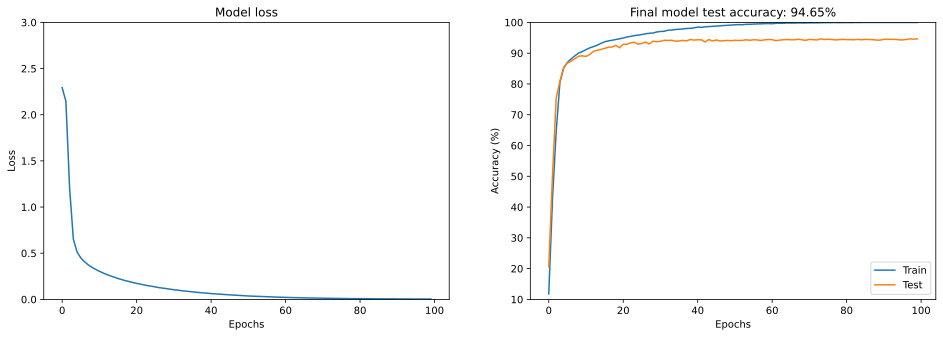

In [9]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

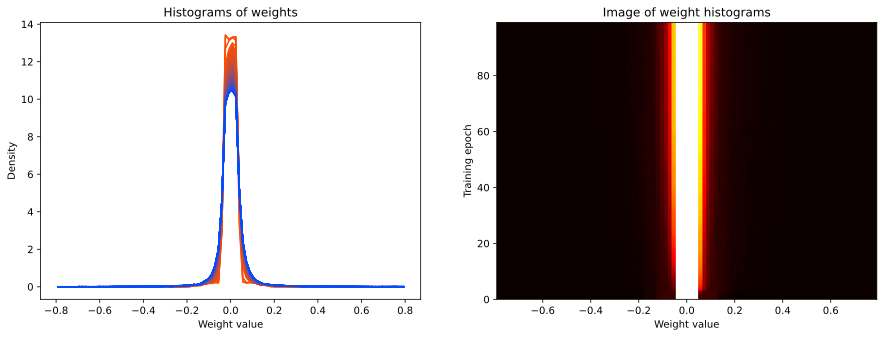

In [10]:
# show the histogram of the weights

fig,ax = plt.subplots(1,2,figsize=(15,5))

for i in range(histy.shape[0]):
  ax[0].plot(histx,histy[i,:],color=[1-i/100,.3,i/100])

ax[0].set_title('Histograms of weights')
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Density')


ax[1].imshow(histy,vmin=0,vmax=3,
             extent=[histx[0],histx[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[1].set_xlabel('Weight value')
ax[1].set_ylabel('Training epoch')
ax[1].set_title('Image of weight histograms')

plt.show()